# 02.2 Random Forest for Rent price

In [93]:
import pandas as pd # Import the library and give a short alias: pd
import warnings
warnings.filterwarnings("ignore")
import time
rent = pd.read_csv("data/rent-ideal.csv")

### Load data 

In [98]:
print(rent.head(5))

   bedrooms  bathrooms  latitude  longitude  price
0         3        1.5   40.7145   -73.9425   3000
1         2        1.0   40.7947   -73.9667   5465
2         1        1.0   40.7388   -74.0018   2850
3         1        1.0   40.7539   -73.9677   3275
4         4        1.0   40.8241   -73.9493   3350


In [99]:
prices = rent['price']
avg_rent = prices.mean()
print(f"Average rent is ${avg_rent:.0f}")

Average rent is $3438


In [100]:
bybaths = rent.groupby(['bathrooms']).mean()
bybaths = bybaths.reset_index() # overcome quirk in Pandas
print(bybaths[['bathrooms','price']]) # print just num baths, avg price

   bathrooms        price
0        0.0  3144.870000
1        1.0  3027.007118
2        1.5  4226.336449
3        2.0  5278.595739
4        2.5  6869.047368
5        3.0  6897.974576
6        3.5  7635.357143
7        4.0  7422.888889
8        4.5  2050.000000
9       10.0  3600.000000


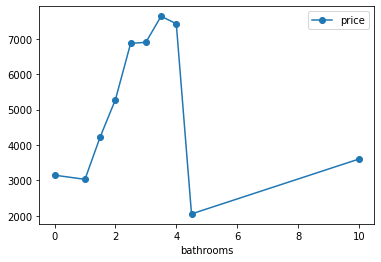

In [101]:
import matplotlib.pyplot as plt

bybaths.plot.line('bathrooms','price', style='-o')
plt.show()

### Train a simple model

In [103]:
X, y = rent[['bedrooms','bathrooms','latitude','longitude']], rent['price']

In [104]:
print(type(X), type(y))

<class 'pandas.core.frame.DataFrame'> <class 'pandas.core.series.Series'>


In [105]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=10) # use 10 trees
rf.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [106]:
unknown_x = [2, 1, 40.7957,-73.97] # 2 bedrooms, 1 bathroom, ...

In [107]:
predicted_y = rf.predict([unknown_x])
print(predicted_y)

[4211.24559397]


### Learning & Generalisation
Let's check if the model is learning correctly from the training data.
aka Training error.

In [74]:
from sklearn.metrics import mean_absolute_error

predictions = rf.predict(X)
e = mean_absolute_error(y, predictions)
ep = e*100.0/y.mean()
print(f"${e:.0f} average error; {ep:.2f}% error")

$189 average error; 5.51% error


How about only learning from just 2 features. (Location)

In [79]:
X, y = rent[['latitude','longitude']], rent['price']
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X, y)
#Mean Absolute Error
location_e = mean_absolute_error(y, rf.predict(X))
location_ep = location_e*100.0/y.mean()
print(f"${location_e:.0f} average error; {location_ep:.2f}% error")

$519 average error; 15.10% error


### Hold-out validation
Let's check the test error

In [108]:
from sklearn.model_selection import train_test_split

X, y = rent[['bedrooms','bathrooms','latitude','longitude']], rent['price']
# 20% of data goes into test set, 80% into training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 

start_time = time.time()
rf = RandomForestRegressor(n_estimators=10)
rf.fit(X_train, y_train)
print(f'Time taken to fit with 10 trees {time.time()-start_time} secs')

validation_e = mean_absolute_error(y_test, rf.predict(X_test))
print(f"${validation_e:.0f} average error; {validation_e*100.0/y.mean():.2f}% error")

Time taken to fit with 10 trees 0.5045130252838135 secs
$306 average error; 8.91% error


Let us try to change some model parameters to see if we can achieve better results.

In [109]:
start_time = time.time()
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
print(f'Time taken to fit with 100 {time.time()-start_time} secs')
e = mean_absolute_error(y_test, rf.predict(X_test))
print(f"${e:.0f} average error; {e*100.0/y.mean():.2f}% error")

Time taken to fit with 100 5.102221250534058 secs
$301 average error; 8.74% error


### Feature Importances

In [113]:
from rfpimp import *
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
I = importances(rf, X_test, y_test)
print(I)

           Importance
Feature              
longitude    0.536937
bedrooms     0.488910
latitude     0.430540
bathrooms    0.415630


Important to calculate feature importance on test data and not training data.

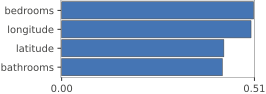

In [111]:
plot_importances(I, color='#4575b4', vscale=1.8)

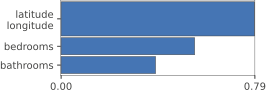

In [112]:
I = importances(rf, X_test, y_test,
                features=['bedrooms','bathrooms',['latitude','longitude']])
plot_importances(I, color='#4575b4', vscale=1.8)